# Test suite for env_template_sa

In [1]:
from marketsai.economies.template_single_agent.env_template_sa import TemplateSA
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time

In [10]:
# environment config
env_config = {
    "horizon": 1000,
    "eval_mode": False,
    "analysis_mode": False,
    "simul_mode": False,
    "max_action": 0.6,
    # "rew_mean": 0.9200565795467147,
    # "rew_std": 0.3003009455512563,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "alpha": 0.36,
        "delta": 0.025,
        "beta": 0.99,
    },
}

def process_rewards(r, BETA):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]


In [8]:
# validate spaces
env = TemplateSA(env_config=env_config)
print(
    "action space type:",
    type(env.action_space.sample()),
    "action space sample:",
    env.action_space.sample(),
)
print(
    "obs space type:",
    type(env.observation_space.sample()),
    "obs space sample:",
    env.observation_space.sample(),
)
obs_init = env.reset()
print(
    "obs_init contained in obs_space?",
    env.observation_space.contains(obs_init),
)
if not env.observation_space.contains(obs_init):
    print(obs_init)
print(
    "random number in [-1,1] contained in action_space?",
    env.action_space.contains(np.array([np.random.uniform(-1, 1)])),
)
obs, rew, done, info = env.step(env.action_space.sample())
print(
    "obs after step contained in obs space?",
    env.observation_space.contains(obs),
        )

action space type: <class 'numpy.ndarray'> action space sample: [0.08278156]
obs space type: <class 'tuple'> obs space sample: (array([11.003309], dtype=float32), array([0]))
obs_init contained in obs_space? True
random number in [-1,1] contained in action_space? True
obs after step contained in obs space? True


In [3]:
data_timing = {
    "time_init": [],
    "time_reset": [],
    "time_step": [],
    "max_passthrough": [],
}

time_preinit = time.time()
env = TemplateSA(env_config=env_config)
time_postinit = time.time()
env.reset()
time_postreset = time.time()
obs, rew, done, info = env.step(np.array([np.random.uniform(-1, 1)]))
time_poststep = time.time()

data_timing["time_init"].append((time_postinit - time_preinit) * 1000)
data_timing["time_reset"].append((time_postreset - time_postinit) * 1000)
data_timing["time_step"].append((time_poststep - time_postreset) * 1000)
data_timing["max_passthrough"].append(1 / (time_poststep - time_postreset))
print(data_timing)

{'time_init': [0.32520294189453125], 'time_reset': [0.10180473327636719], 'time_step': [0.1862049102783203], 'max_passthrough': [5370.427656850192]}


In [6]:
# simulate
SIMUL_PERIODS = 1000000
env = TemplateSA(env_config=env_config)
print("steady_state", env.k_ss)
cap_stats, rew_stats = env.random_sample(SIMUL_PERIODS)
print("[cap_max, cap_min, cap_mean, cap_std]:", cap_stats, "\n" + "[rew_max, rew_min, rew_mean, rew_std:]", rew_stats)

37.989253538152255
[cap_max, cap_min, cap_mean, cap_std]: [56.98388030722838, 3.8121257518819465, 40.0022916457265, 9.276831277282598] 
[rew_max, rew_min, rew_mean, rew_std:] [1.5506529013641641, -0.47561313810699063, 0.9200608137296913, 0.30008477036430903]


Discounted Rewards 83.03131817830474 
cap_stats: [54.10210061635993, 11.396776061445676, 44.88374221620084, 6.6711827906885794] 
reward_stats: [1.4872339112914952, -0.06738138063839443, 0.9766925477655505, 0.2834907337815398]


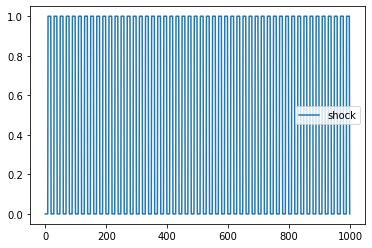

In [11]:
# run analysis mode
env_config_analysis = env_config.copy()
env_config_analysis["analysis_mode"] = True
env = TemplateSA(env_config=env_config_analysis)
k_list = []
rew_list = []
shock_list = []

env.reset()
for t in range(1000):
    if t % 1000 == 0:
        obs = env.reset()
    obs, rew, done, info = env.step(env.action_space.sample())
    shock_list.append(env.obs_global[1])
    k_list.append(info["capital"])
    rew_list.append(info["rewards"])
disc_rew = process_rewards(rew_list,0.99)
print("Discounted Rewards", disc_rew,
    "\n"+"cap_stats:",
    [
        np.max(k_list),
        np.min(k_list),
        np.mean(k_list),
        np.std(k_list),
    ],
    "\n"+"reward_stats:",
    [np.max(rew_list), np.min(rew_list), np.mean(rew_list), np.std(rew_list)],
)
plt.plot(shock_list)
plt.legend(["shock"])
plt.show()

In [ ]:
# run evaluation mode
env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
env_config_eval["simul_mode"] = True
env = TemplateSA(env_config=env_config_eval)
k_list = []
rew_list = []
shock_list = []

env.reset()
for t in range(200):
    if t % 200 == 0:
        obs = env.reset()
    obs, rew, done, info = env.step(env.action_space.sample())
    # print(obs, "\n", rew, "\n", done, "\n", info)

    k_list.append(info["capital"])
    shock_list.append(env.obs_global[1])
    rew_list.append(info["rewards"])
print(
    "cap_stats:",
    [
        np.max(k_list),
        np.min(k_list),
        np.mean(k_list),
        np.std(k_list),
    ],
    "reward_stats:",
    [np.max(rew_list), np.min(rew_list), np.mean(rew_list), np.std(rew_list)],
)

plt.plot(shock_list)
plt.legend(["shock"])
plt.show()
